# Datasets comparison between CAMS and TROPOMI (L3)

## Imports and supporting functions

In [1]:
# Related to the system
import os 

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3
import subprocess # Important for GOME-2 and TROPOMI L3
import gzip # Important for TROPOMI L3

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display
import warnings

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_tropomi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

# Hide labels animation warning
warnings.filterwarnings('ignore', category = UserWarning, module='cartopy')

## 1. Define datasets

In [4]:
# Define component (NO2)
component_nom = 'NO2'

# Define model
model = 'cams'
model_full_name = 'cams-global-reanalysis-eac4-monthly'

# Define sensor
sensor = 'tropomi'
sensor_type = 'L3'
apply_kernels = False

# Define search period
start_date = '2019-01-01'
end_date = '2021-12-31'

# Define extent
area_name = 'Spain'
lon_min = -20
lon_max = 5
lat_min = 27
lat_max = 45

# Define resolution (Unique: 0.125x.0.125)
lat_res = 1
lon_res = 1

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type, apply_kernels)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column, column_type = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [6]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In months: ('2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12')
SEARCH BOUNDING BOX
Latitudes: from 27 to 45
Longitudes: from -20 to 5


## 2. Model data

### Download and read data as xarray

In [7]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               lat_min, lat_max, lon_min, lon_max, area_name, model_full_name, 
                                               model_level = 'Single', CAMS_UID = None, CAMS_key = None)

The file exists, it will not be downloaded again.


In [8]:
model_ds, dates, model_levels_df = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 25, longitude: 34, time: 30)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2021-06-01
    surface     float64 ...
  * latitude    (latitude) float64 27.0 27.75 28.5 29.25 ... 43.5 44.25 45.0
  * longitude   (longitude) float64 -20.0 -19.25 -18.5 -17.75 ... 3.25 4.0 4.75
    valid_time  (time) datetime64[ns] ...
Data variables:
    component   (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-22T22:33 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [9]:
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],Depth [m]
hybrid,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2320.96
...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,22.96


### Convert CAMS data units (kg/kg to molecules/cm<sup>2</sup>)

In [10]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_mol_weight, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels,
                                      CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg m**-2 to molec cm-2.


In [11]:
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 25, longitude: 34, time: 30)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2021-06-01
    surface     float64 0.0
  * latitude    (latitude) float64 27.0 27.75 28.5 29.25 ... 43.5 44.25 45.0
  * longitude   (longitude) float64 -20.0 -19.25 -18.5 -17.75 ... 3.25 4.0 4.75
    valid_time  (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2021-06-01
Data variables:
    component   (time, latitude, longitude) float32 1.112e+15 ... 3.275e+15
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-22T22:33 GRIB to CDM+CF via cfgrib-0.9.9...

### Get CAMS levels (total or tropospheric)

In [12]:
model_ds = CAMS_get_levels_data(model_ds, model_product_name, model_levels_df, 
                                column_type, lat_min, lat_max, lon_min, lon_max)
model_ds

The model total columns will be directly compared to the tropospheric sensor columns.


<xarray.Dataset>
Dimensions:     (latitude: 25, longitude: 34, time: 30)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2021-06-01
    surface     float64 0.0
  * latitude    (latitude) float64 27.0 27.75 28.5 29.25 ... 43.5 44.25 45.0
  * longitude   (longitude) float64 -20.0 -19.25 -18.5 -17.75 ... 3.25 4.0 4.75
    valid_time  (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2021-06-01
Data variables:
    component   (time, latitude, longitude) float32 1.112e+15 ... 3.275e+15
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-22T22:33 GRIB to CDM+CF via cfgrib-0.9.9...

## 3. Sensor data

### Download and read data as xarray

In [13]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, bbox, product_type)

RESULTS
TROPOMI_L3_NO2_COLUMN_201901.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201902.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201903.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201904.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201905.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201906.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201907.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201908.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201909.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201910.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201911.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201912.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_202001.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_202002.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_202003.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_202004.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_202005.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_202006.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_202007.asc.gz was downloaded.
TROP

In [14]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, sensor_column, component_nom, dates)
sensor_ds

<xarray.Dataset>
Dimensions:        (latitude: 180, longitude: 360, time: 30)
Coordinates:
  * longitude      (longitude) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude       (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time           (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2021-06-01
Data variables:
    sensor_column  (longitude, latitude, time) float64 1.453e+13 ... 3.592e+13

## 4. Match data

In [15]:
match_df = generate_match_df(sensor_ds, model_ds, bbox, sensor, component_nom, sensor_type, apply_kernels)
match_df

FOR MONTH: 2019-01
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2019-02
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2019-03
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2019-04
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2019-05
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2019-06
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2019-07
The model dataset does not contain levels data.
The model dataset will be merged with the sensor da

,latitude,longitude,time,sensor_column,model_column
0,26.5,-20.5,2019-01-01,6.532812e+14,1.112127e+15
1,26.5,-19.5,2019-01-01,6.948438e+14,1.173653e+15
2,26.5,-18.5,2019-01-01,7.653125e+14,1.257369e+15
3,26.5,-17.5,2019-01-01,8.173438e+14,1.364014e+15
4,26.5,-16.5,2019-01-01,8.681250e+14,1.585831e+15
...,...,...,...,...,...
489,44.5,0.5,2021-06-01,1.551094e+15,3.176016e+15
490,44.5,1.5,2021-06-01,1.448750e+15,3.112587e+15
491,44.5,2.5,2021-06-01,1.368438e+15,2.916415e+15
492,44.5,3.5,2021-06-01,1.262031e+15,2.893347e+15


## 5. Merge data and calculate difference

In [16]:
merge_df = generate_merge_df(match_df, sensor_ds, model_ds, sensor, apply_kernels)
merge_df

model_column  sensor_column    difference  \
latitude longitude time                                                    
26.5     -20.5     2019-01-01  1.112127e+15   6.532812e+14  4.588456e+14   
         -19.5     2019-01-01  1.173653e+15   6.948438e+14  4.788095e+14   
         -18.5     2019-01-01  1.257369e+15   7.653125e+14  4.920561e+14   
         -17.5     2019-01-01  1.364014e+15   8.173438e+14  5.466704e+14   
         -16.5     2019-01-01  1.585831e+15   8.681250e+14  7.177063e+14   
...                                     ...            ...           ...   
44.5      0.5      2021-06-01  3.176016e+15   1.551094e+15  1.624922e+15   
          1.5      2021-06-01  3.112587e+15   1.448750e+15  1.663837e+15   
          2.5      2021-06-01  2.916415e+15   1.368438e+15  1.547977e+15   
          3.5      2021-06-01  2.893347e+15   1.262031e+15  1.631315e+15   
          4.5      2021-06-01  3.410311e+15   1.471250e+15  1.939061e+15   

                               relative_difference  
latitude longitude time                             
26.5     -20.5     2019-01-01             0.702371  
         -19.5     2019-01-01             0.689089  
         -18.5     2019-01-01             0.642948  
         -17.5     2019-01-01             0.668838  
         -16.5     2019-01-01             0.826732  
...                                            ...  
44.5      0.5      2021-06-01             1.047598  
          1.5      2021-06-01             1.148464  
          2.5      2021-06-01             1.131200  
          3.5      2021-06-01             1.292611  
          4.5      2021-06-01             1.317969  

[14820 rows x 4 columns]

In [17]:
descr_stats_table = merge_df.describe()
descr_stats_table

,model_column,sensor_column,difference,relative_difference
count,1.482000e+04,1.482000e+04,1.482000e+04,14820.000000
mean,2.238690e+15,9.084089e+14,1.330281e+15,1.556637
std,9.489457e+14,4.459650e+14,5.950277e+14,0.485765
min,1.083223e+15,2.526562e+14,2.612758e+14,0.055851
25%,1.573988e+15,6.121484e+14,9.568188e+14,1.233419
50%,1.848516e+15,7.349219e+14,1.163169e+15,1.526002
75%,2.789922e+15,1.118125e+15,1.589132e+15,1.837222
max,1.072097e+16,5.636094e+15,6.512380e+15,5.594869


## 6. Show comparison plots

### Select plot dates

In [19]:
plot_dates = plot_period(sensor_ds, sensor_type)

The plots will be shown for the following dates:
['2019-01' '2019-02' '2019-03' '2019-04' '2019-05' '2019-06' '2019-07'
 '2019-08' '2019-09' '2019-10' '2019-11' '2019-12' '2020-01' '2020-02'
 '2020-03' '2020-04' '2020-05' '2020-06' '2020-07' '2020-08' '2020-09'
 '2020-10' '2020-11' '2020-12' '2021-01' '2021-02' '2021-03' '2021-04'
 '2021-05' '2021-06']


### Select plot extent

In [20]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-20, 27), (5, 45))


### Compare CAMS and TROPOMI total columns

Frame length between -20 and 5 should be one of these options: [1, 5, 25]
Frame length between 27 and 45 should be one of these options: [1, 2, 3, 6, 9, 18]


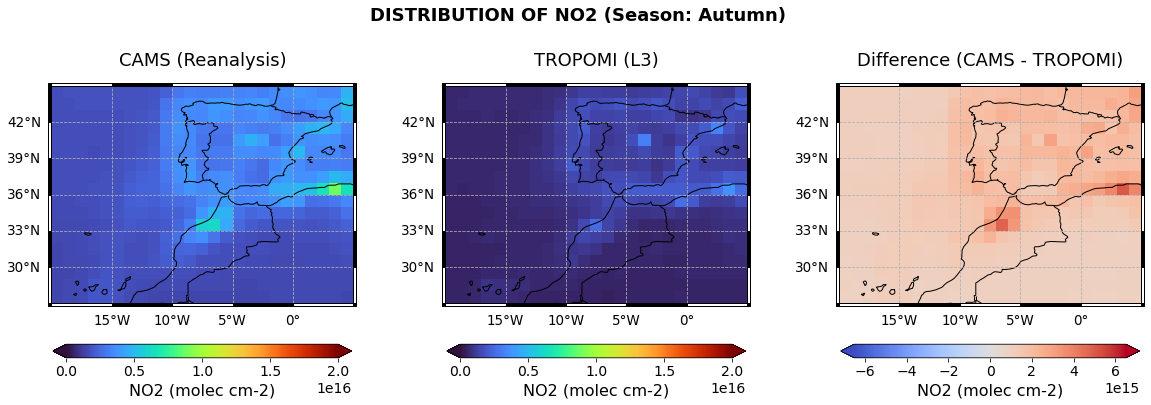

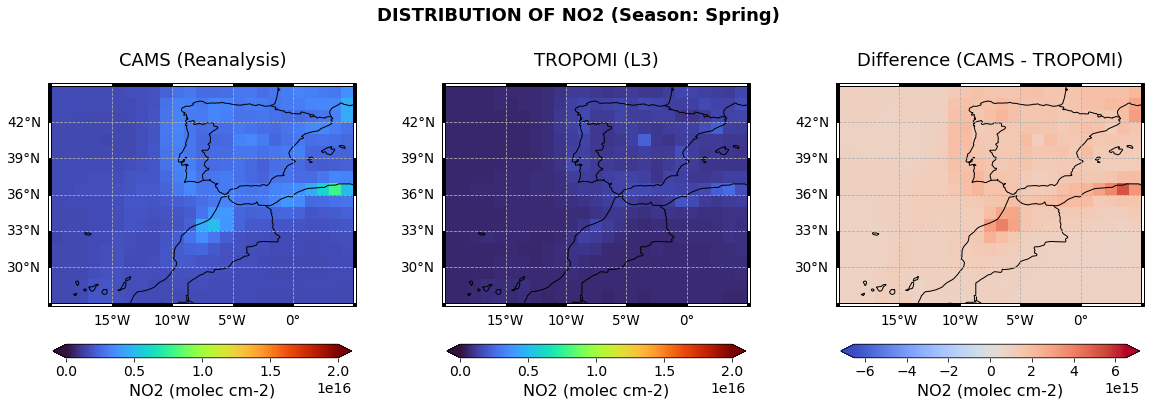

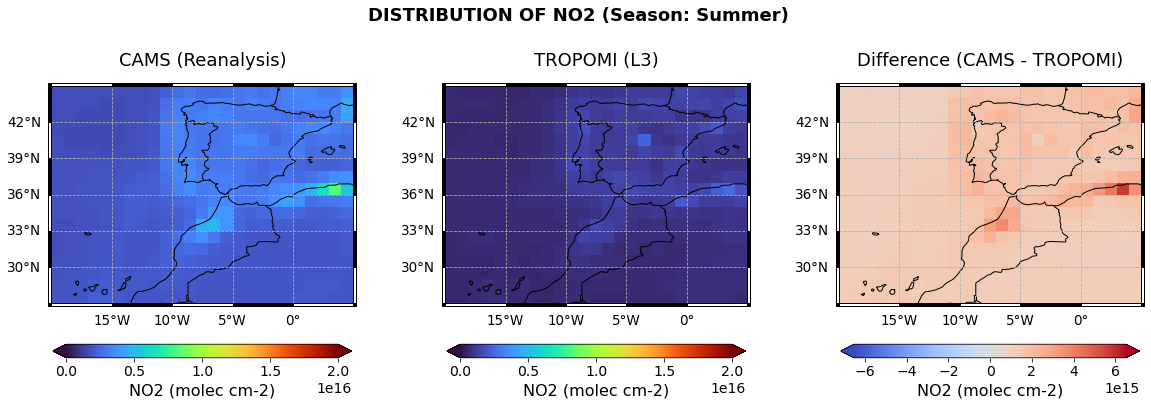

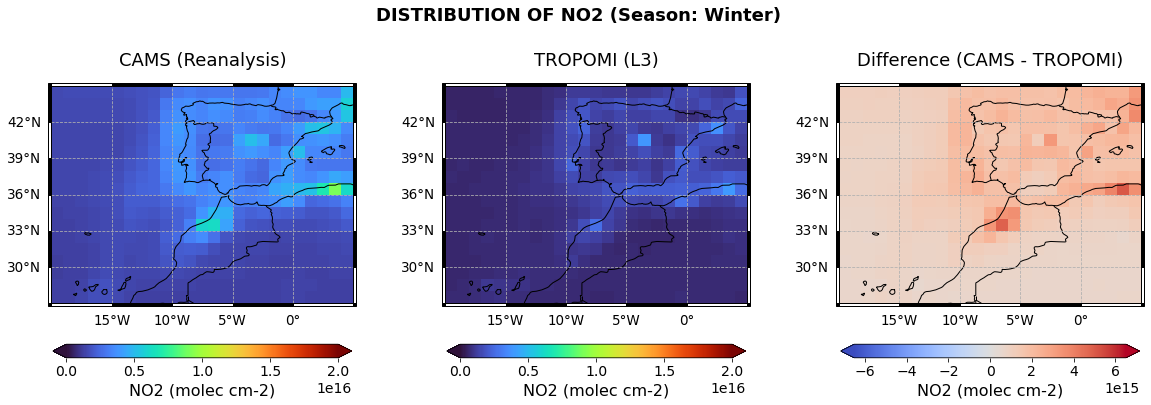

In [21]:
# Choose distribution (aggregated, individual, seasonal or animated)
distribution_type = 'seasonal'

# Define range (original, equal, centered or manual)
range_type = 'manual'
vmin_manual, vmax_manual = 0, 2*10**16
vmin_manual_diff, vmax_manual_diff = None, None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = ['turbo', 'turbo', 'coolwarm']

# Get and decide the best width and height of the B/W frame lines
options_height_lon = get_frame_possible_lengths(lon_min, lon_max)
options_width_lat = get_frame_possible_lengths(lat_min, lat_max)
width_lon = 5
height_lat = 3

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_df, plot_dates, plot_bbox, 20, 1.10, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, width_lon, height_lat, vmin_manual, vmax_manual,
                          vmin_manual_diff, vmax_manual_diff,
                          bbox_list = None, coords_list = None, regions_names = None)

## 7. Retrieve nearest values to specific coordinates

model_column  \
region    lat_search lon_search latitude longitude time                       
Barcelona 41.37       2.17      41.5      2.5      2019-01-01  6.512274e+15   
                                                   2019-02-01  6.035588e+15   
                                                   2019-03-01  5.065300e+15   
                                                   2019-04-01  3.962358e+15   
                                                   2019-05-01  3.531218e+15   
                                                   2019-06-01  3.072687e+15   
                                                   2019-07-01  3.007387e+15   
                                                   2019-08-01  3.208034e+15   
                                                   2019-09-01  4.122072e+15   
                                                   2019-10-01  4.396952e+15   
                                                   2019-11-01  4.936754e+15   
                                                   2019-12-01  5.909442e+15   
                                                   2020-01-01  5.841800e+15   
                                                   2020-02-01  5.262834e+15   
                                                   2020-03-01  4.489044e+15   
                                                   2020-04-01  3.749117e+15   
                                                   2020-05-01  3.400281e+15   
                                                   2020-06-01  2.996289e+15   
                                                   2020-07-01  3.005470e+15   
                                                   2020-08-01  3.061352e+15   
                                                   2020-09-01  4.001865e+15   
                                                   2020-10-01  4.100136e+15   
                                                   2020-11-01  5.047627e+15   
                                                   2020-12-01  5.095143e+15   
                                                   2021-01-01  5.762970e+15   
                                                   2021-02-01  4.762767e+15   
                                                   2021-03-01  4.782591e+15   
                                                   2021-04-01  3.857457e+15   
                                                   2021-05-01  3.183588e+15   
                                                   2021-06-01  2.800220e+15   
Madrid    40.37      -3.68      40.5     -3.5      2019-01-01  6.264819e+15   
                                                   2019-02-01  4.939401e+15   
                                                   2019-03-01  4.139888e+15   
                                                   2019-04-01  3.606059e+15   
                                                   2019-05-01  3.239699e+15   
                                                   2019-06-01  2.934764e+15   
                                                   2019-07-01  3.157652e+15   
                                                   2019-08-01  3.483857e+15   
                                                   2019-09-01  3.970863e+15   
                                                   2019-10-01  4.558811e+15   
                                                   2019-11-01  4.207343e+15   
                                                   2019-12-01  5.669614e+15   
                                                   2020-01-01  6.514583e+15   
                                                   2020-02-01  5.556698e+15   
                                                   2020-03-01  4.192387e+15   
                                                   2020-04-01  3.848700e+15   
                                                   2020-05-01  3.375457e+15   
                                                   2020-06-01  3.128849e+15   
                                                   2020-07-01  3.181858e+15   
                                  

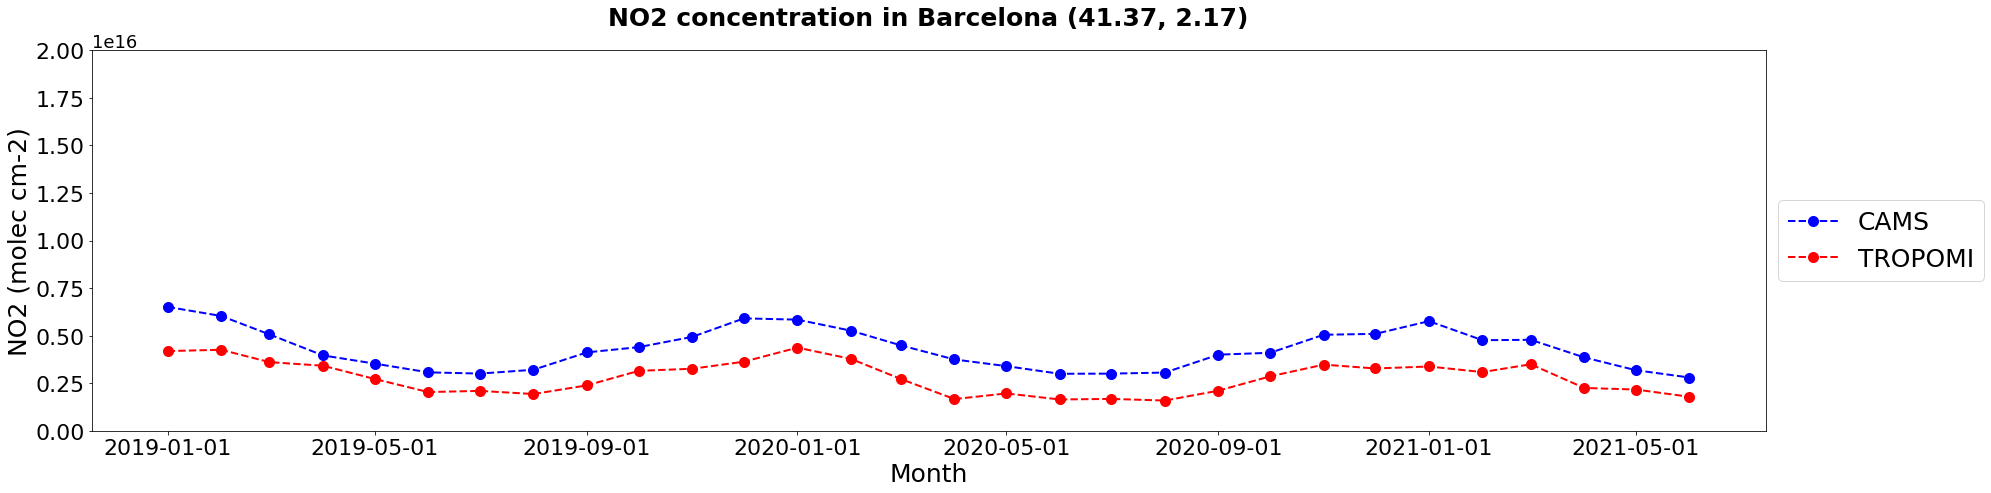

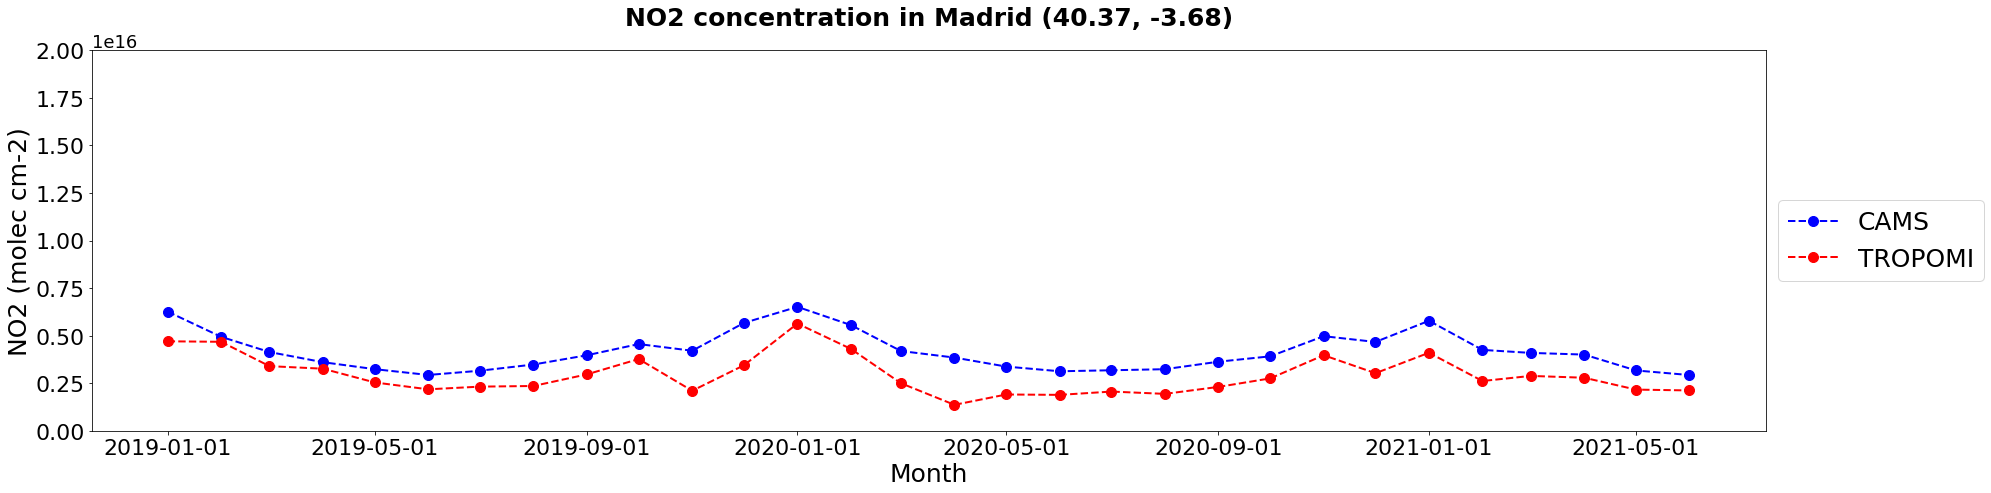

In [22]:
regions_names = ('Barcelona', 'Madrid')
coords_list = (41.37, 2.17,
               40.37, -3.68)
ymin = 0
ymax = 2*10**16
xticks = plot_dates[0::4]

timeseries_table = timeseries(merge_df, component_nom, sensor, sensor_type, model, 
                              plot_dates, units, ymin, ymax, xticks, regions_names, coords_list)
timeseries_table

## 8. Monthly annual cycle

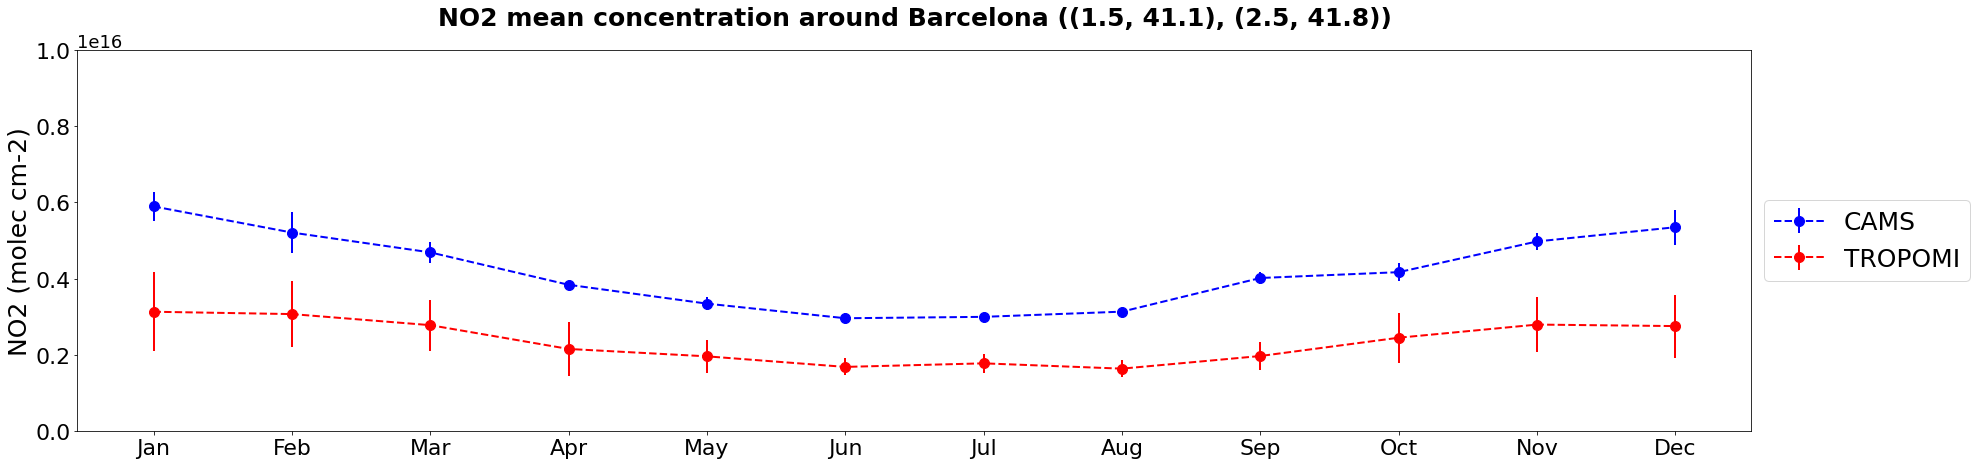

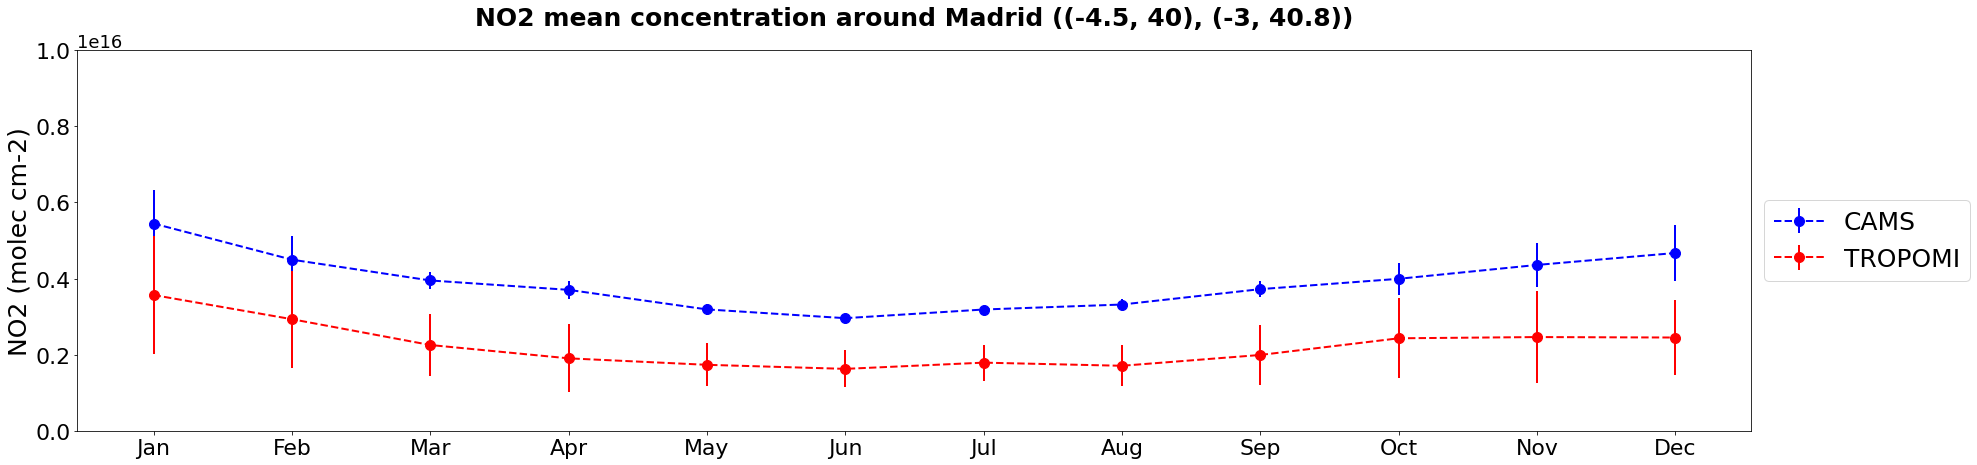

,location,month,model mean,model std,sensor mean,sensor std
0,Barcelona,1,5.897210e+15,3.824705e+14,3.128776e+15,1.044527e+15
1,Barcelona,2,5.210098e+15,5.296035e+14,3.067344e+15,8.578362e+14
2,Barcelona,3,4.689112e+15,2.846236e+14,2.776406e+15,6.739769e+14
3,Barcelona,4,3.837335e+15,8.898543e+13,2.150990e+15,7.097063e+14
4,Barcelona,5,3.341939e+15,1.661253e+14,1.956849e+15,4.413078e+14
5,Barcelona,6,2.958115e+15,1.261514e+14,1.679219e+15,2.210268e+14
6,Barcelona,7,2.994662e+15,2.882279e+13,1.772695e+15,2.417722e+14
7,Barcelona,8,3.131278e+15,1.000521e+14,1.633438e+15,2.175444e+14
8,Barcelona,9,4.015695e+15,1.490520e+14,1.965469e+15,3.726442e+14
9,Barcelona,10,4.168910e+15,2.442819e+14,2.445938e+15,6.600211e+14


In [23]:
regions_names = ('Barcelona', 'Madrid')
bbox_list = (41.1, 41.8, 1.5, 2.5,
             40, 40.8, -4.5, -3)
ymin = 0
ymax = 1*10**16

monthly_annual_cycle_table = monthly_annual_cycle(merge_df, component_nom, sensor, model, units, 
                                                  ymin, ymax, regions_names, bbox_list)
monthly_annual_cycle_table

## 9. Trends

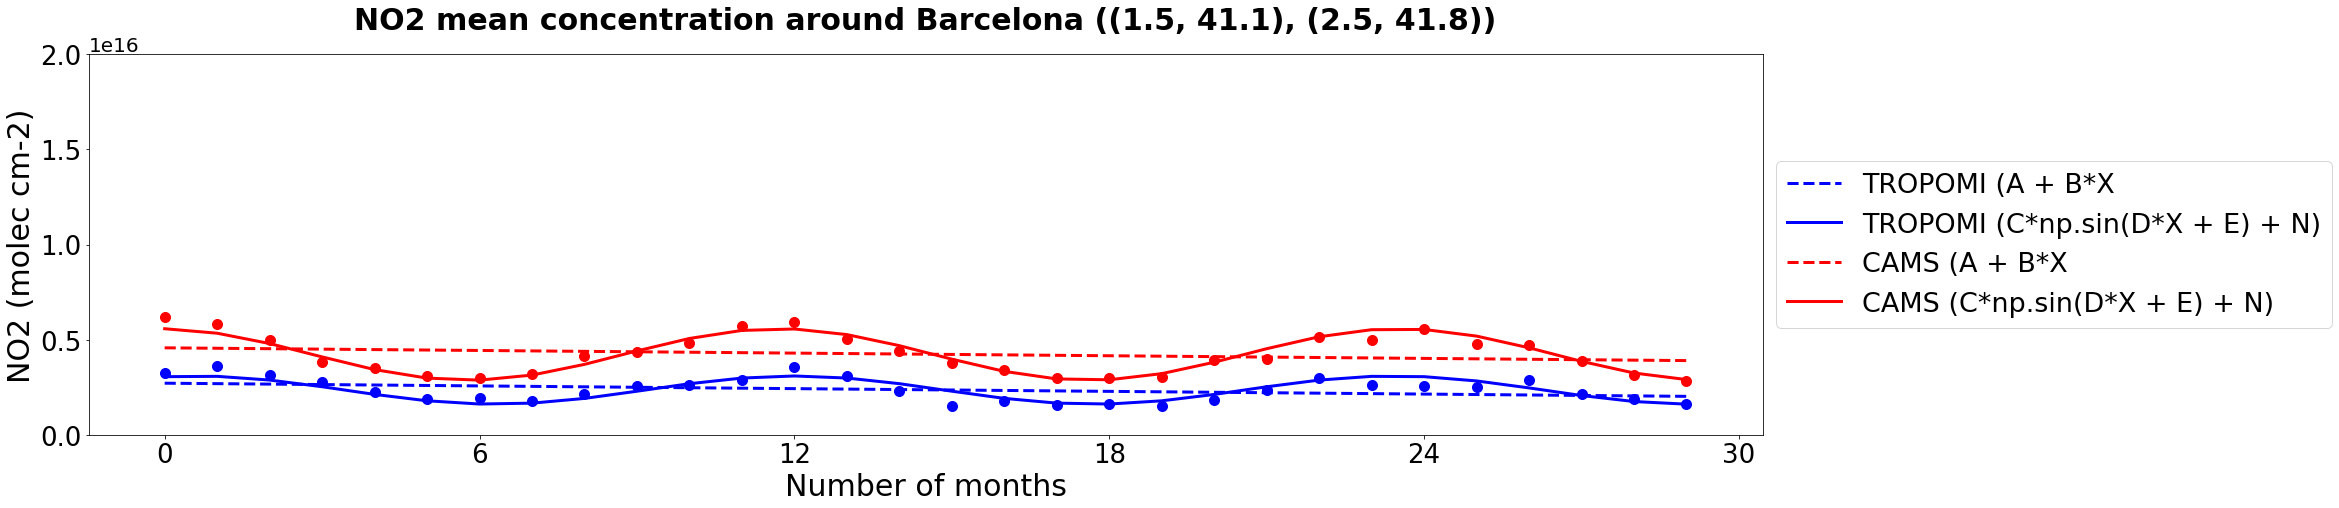

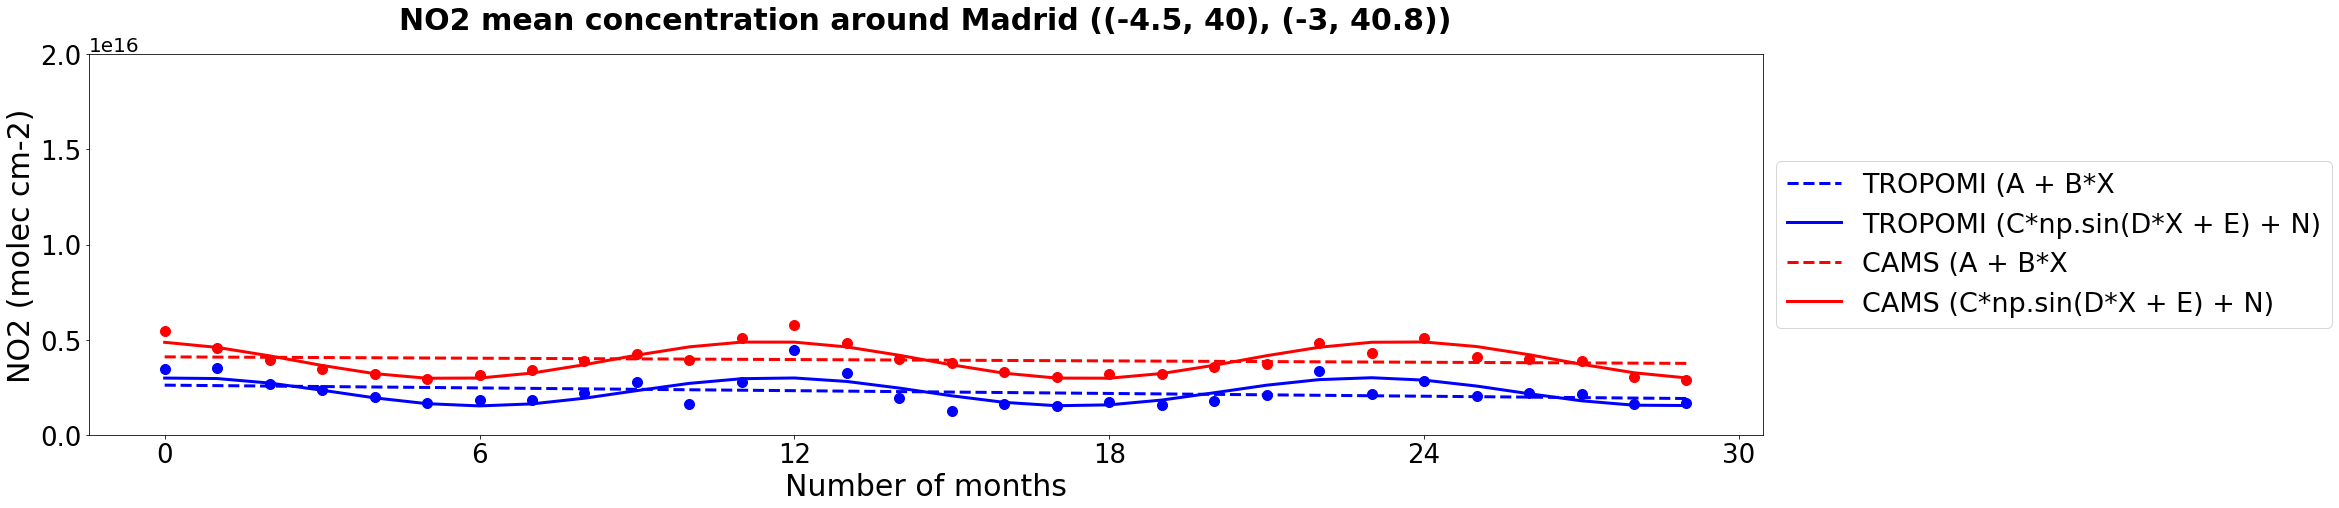

,Location,Source,Rate (molec cm-2 y-1),Rate (% y-1),A,B,C,D,E,N,Linear R2,Linear RMSE,Linear MSE,Sinusoidal R2,Sinusoidal RMSE,Sinusoidal MSE
0,Barcelona,Sensor,-2.859075e+14,-10.541682,2.712162e+15,-2.382562e+13,7.421344e+14,0.550075,1.251370,2.350223e+15,0.112529,5.791328e+14,3.353948e+29,0.758554,3.020727e+14,9.124791e+28
1,Barcelona,Model,-2.776291e+14,-6.073300,4.571305e+15,-2.313576e+13,1.357320e+15,0.530920,-4.640432,4.221508e+15,0.039741,9.843482e+14,9.689414e+29,0.925612,2.739713e+14,7.506030e+28
0,Madrid,Sensor,-2.906018e+14,-11.137168,2.609298e+15,-2.421682e+13,-7.407489e+14,0.557183,-1.785873,2.258947e+15,0.082225,7.002832e+14,4.903965e+29,0.540813,4.953366e+14,2.453584e+29
1,Madrid,Model,-1.413994e+14,-3.452006,4.096151e+15,-1.178328e+13,-9.798248e+14,0.520878,-1.273175,3.924833e+15,0.017801,7.575847e+14,5.739346e+29,0.817006,3.270015e+14,1.069300e+29


In [24]:
regions_names = ('Barcelona', 'Madrid')
bbox_list = (41.1, 41.8, 1.5, 2.5,
             40, 40.8, -4.5, -3)
ymin = 0
ymax = 2*10**16
sensor_break_date = None # None or date as a string
model_break_date = None # None or date as a string

trends_table = trends(merge_df, component_nom, sensor, model, units, ymin, ymax, 
                      plot_dates, regions_names, bbox_list, sensor_break_date, model_break_date)
trends_table

Frame length between -20 and 5 should be one of these options: [1, 5, 25]
Frame length between 27 and 45 should be one of these options: [1, 2, 3, 6, 9, 18]


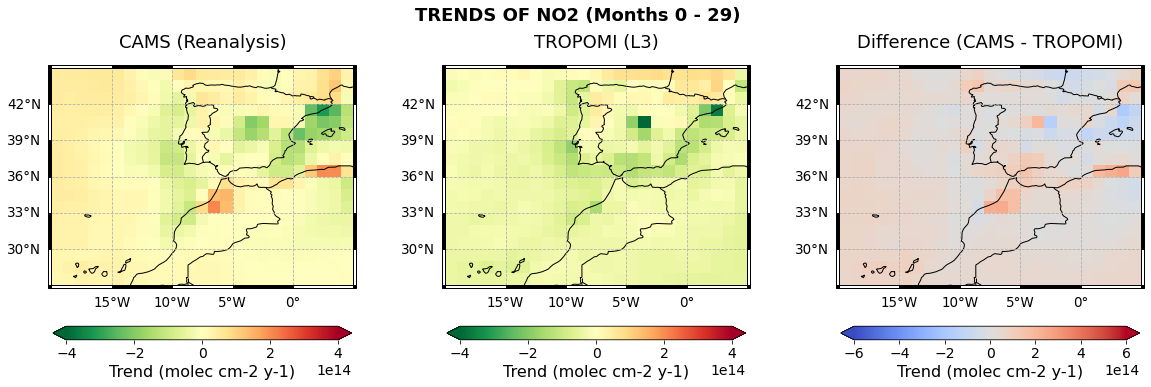

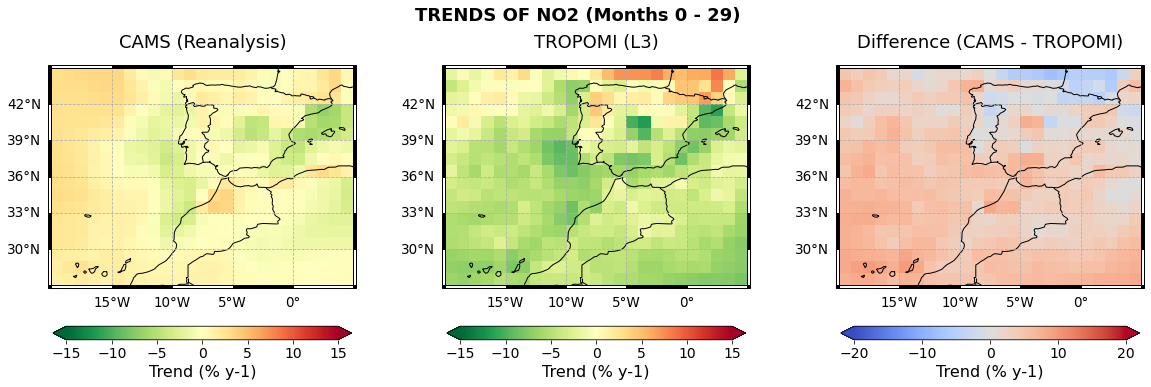

In [25]:
# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = ['RdYlGn_r', 'RdYlGn_r', 'coolwarm']

# Get and decide the best width and height of the B/W frame lines
options_height_lon = get_frame_possible_lengths(lon_min, lon_max)
options_width_lat = get_frame_possible_lengths(lat_min, lat_max)
width_lon = 5
height_lat = 3

# Define break dates (None or both the same)
sensor_break_date = None # None or date as a string
model_break_date = None # None or date as a string

# Define range
vmax_manual_rate_units, vmin_manual_rate_units = 4*10**14, -4*10**14
vmax_manual_diff_units, vmin_manual_diff_units = 6*10**14, -6*10**14
vmax_manual_rate_100, vmin_manual_rate_100 = 15, -15
vmax_manual_diff_100, vmin_manual_diff_100 = 20, -20

bbox_trends_table = visualize_bbox_trends(merge_df, component_nom, sensor, model, units, plot_dates, 
                                          sensor_break_date, model_break_date, 20, 1.05,
                                          vmin_manual_rate_units, vmax_manual_rate_units, 
                                          vmin_manual_rate_100, vmax_manual_rate_100,
                                          vmin_manual_diff_units, vmax_manual_diff_units, 
                                          vmin_manual_diff_100, vmax_manual_diff_100,
                                          width_lon, height_lat, 
                                          bbox_list = None, coords_list = None, regions_names = None)

## 10. Scatter plots by bbox

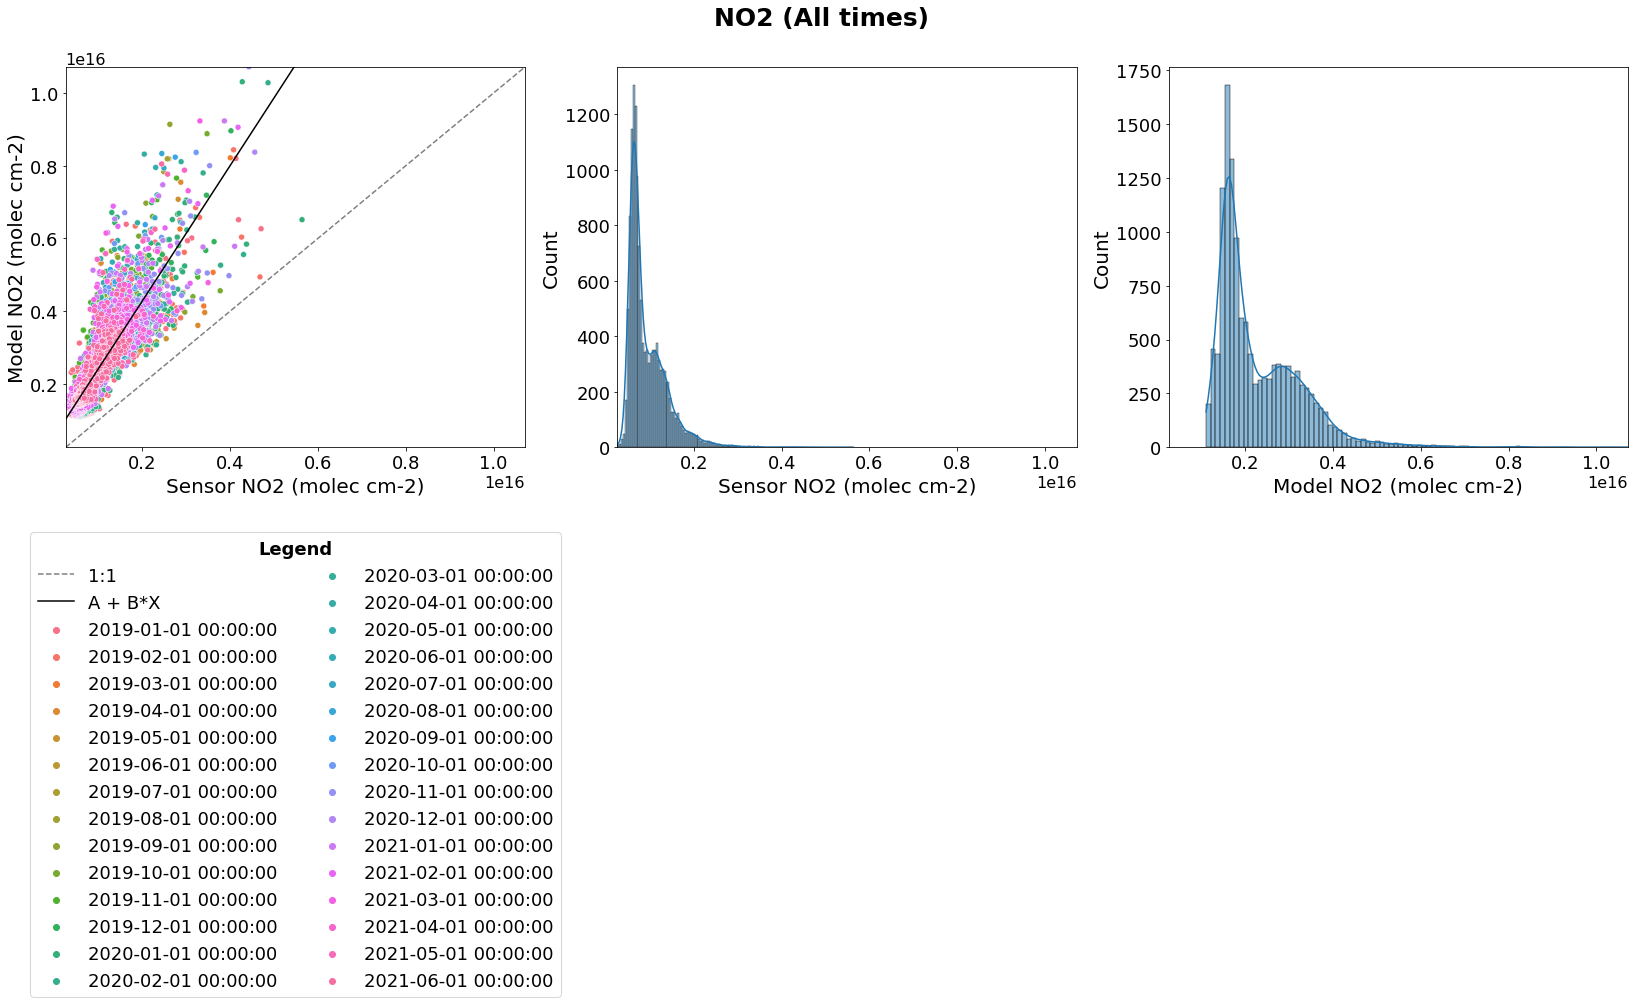

,Period,Location,A,B,R2,RMSE,MSE
0,"[2019-01-01T00:00:00.000000000, 2019-02-01T00:...","((-20, 27), (5, 45))",1.861987,5.576992e+14,0.769749,4.631823e+14,2.145379e+29


In [26]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)
summary

## 11. Scatter plots by season

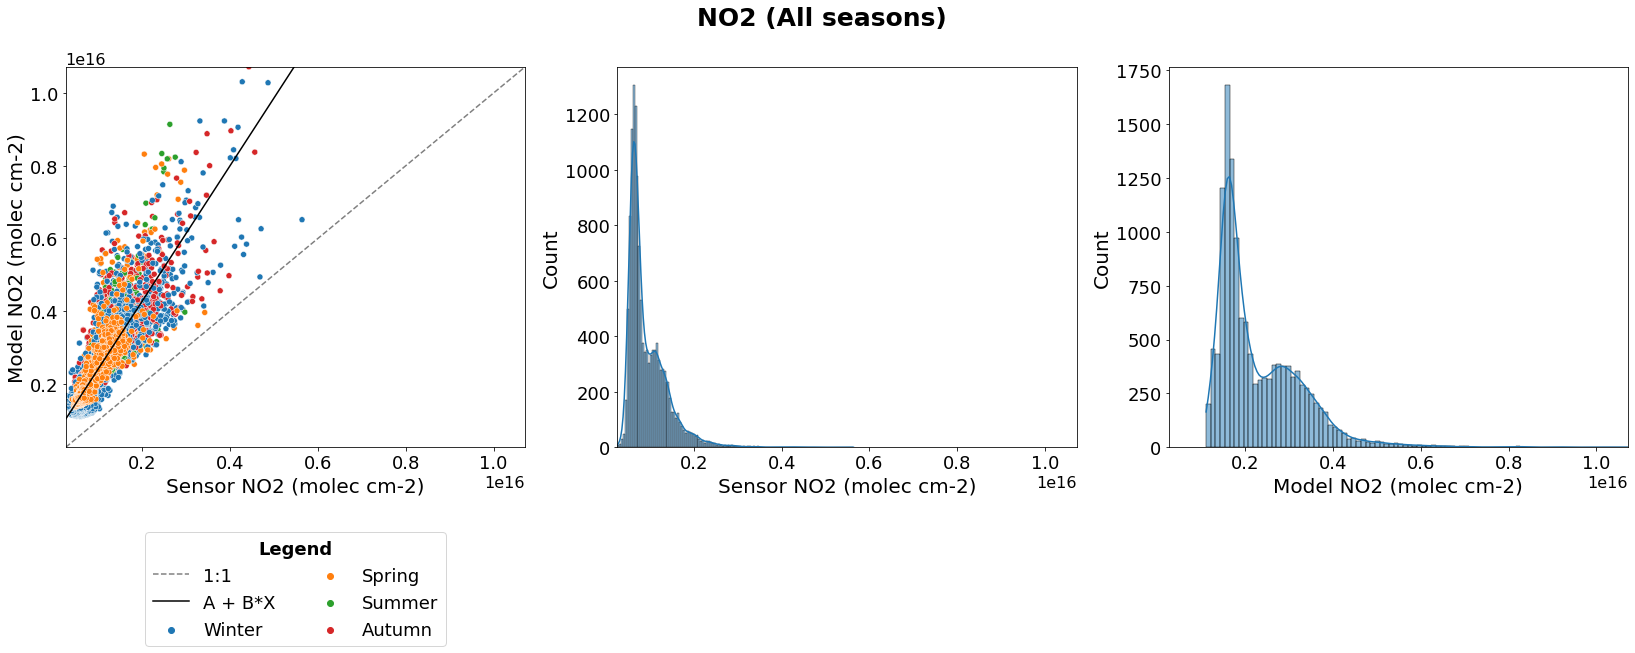

,Period,Location,A,B,R2,RMSE,MSE
0,"[Autumn, Spring, Summer, Winter]","((-20, 27), (5, 45))",1.861987,5.576992e+14,0.769749,4.631823e+14,2.145379e+29


In [27]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)
summary

## 12. Scatter plots by country (Google API required!)

In [28]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
plot_countries = ['Czech Republic', 'Poland', 'Germany']

lim_min = None
lim_max = None

scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1.05, 
             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
summary 
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'aggregated' # aggregated or individual\nplot_countries = ['Czech Republic', 'Poland', 'Germany']\n\nlim_min = None\nlim_max = None\n\nscatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1.05, \n             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\nsummary \n"